# Word2Vec

The code for this lecture is based off the great tutorial example from tensorflow!

Walkthrough:

https://www.tensorflow.org/tutorials/word2vec

Raw Code: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

# Step 0: Imports

In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

C:\Users\caiyi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\caiyi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\caiyi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\caiyi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# Step 1: The data.

In [2]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [4]:
# Use Defaults (this make take awhile!!)
words = fetch_words_data()

In [5]:
# Total words
len(words)

17005207

In [6]:
words[0:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [7]:
# Random slice of words
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [8]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

## Build Word Counts

In [9]:
from collections import Counter

In [10]:
mylist = ["one",'one','two']

In [11]:
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [12]:
Counter(mylist).most_common(1)

[('one', 2)]

In [13]:
Y=Counter(words[:]).most_common(10)

In [14]:
Y

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

In [15]:
V = np.array([word for word, _ in Y])

In [16]:
V

array(['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two'],
      dtype='<U4')

In [17]:
list(enumerate(V))

[(0, 'the'),
 (1, 'of'),
 (2, 'and'),
 (3, 'one'),
 (4, 'in'),
 (5, 'a'),
 (6, 'to'),
 (7, 'zero'),
 (8, 'nine'),
 (9, 'two')]

In [18]:
 d = {word: code for code, word in enumerate(V)}

In [19]:
d

{'the': 0,
 'of': 1,
 'and': 2,
 'one': 3,
 'in': 4,
 'a': 5,
 'to': 6,
 'zero': 7,
 'nine': 8,
 'two': 9}

In [20]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

x = car.get("price", 15000)

print(x)

15000


## Create Word Data and Vocab

In [21]:
def create_counts(vocab_size=50000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn into a numpy array,'_' means not use it 
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [22]:
vocab_size = 50000

In [23]:
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)

In [24]:
data

array([5233, 3080,   11, ...,   21,   15,   72])

In [25]:
(words[0],data[0])

('anarchism', 5233)

In [26]:
vocabulary.shape

(50000,)

In [27]:
vocabulary[np.random.randint(0,50000)]

're'

## Function for Batches

Direct from the word2vec file from TensorFlow Docs

In [28]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [29]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [30]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080])

In [31]:
labels

array([[5233],
       [  11],
       [5233],
       [  11],
       [  11],
       [5233],
       [5233],
       [  11]])

## Constants

In [32]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2        

In [33]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [34]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [35]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [36]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [37]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [38]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

W1229 21:14:09.017932 26572 deprecation.py:323] From C:\Users\caiyi\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Optimizer

In [39]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [40]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

W1229 21:14:11.938968 26572 deprecation.py:506] From <ipython-input-40-4b6601cc344f>:2: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [41]:
# Add variable initializer.
init = tf.global_variables_initializer()

# Session

In [42]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [43]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 5000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  284.2542724609375
Average loss at step  1000 :  10010.628792831421
Average loss at step  2000 :  22540.483062086107
Average loss at step  3000 :  27302.971730136873
Average loss at step  4000 :  33143.30335041809


# Visualizing Results

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [46]:
type(final_embeddings)

numpy.ndarray

In [47]:
final_embeddings.shape

(50000, 150)

In [48]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [49]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [50]:
labels = [vocabulary[i] for i in range(plot_only)]

In [51]:
low_dim_embs.shape

(2000, 2)

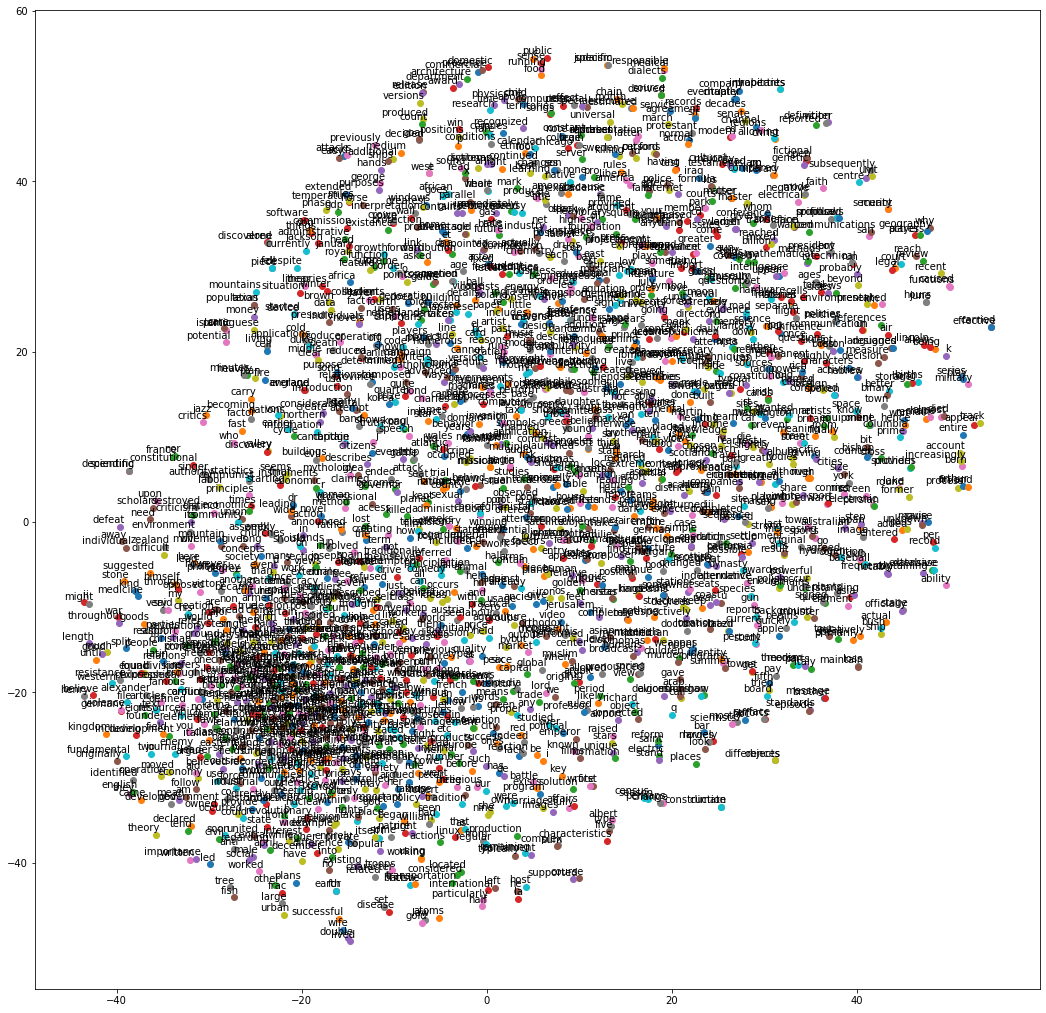

In [52]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

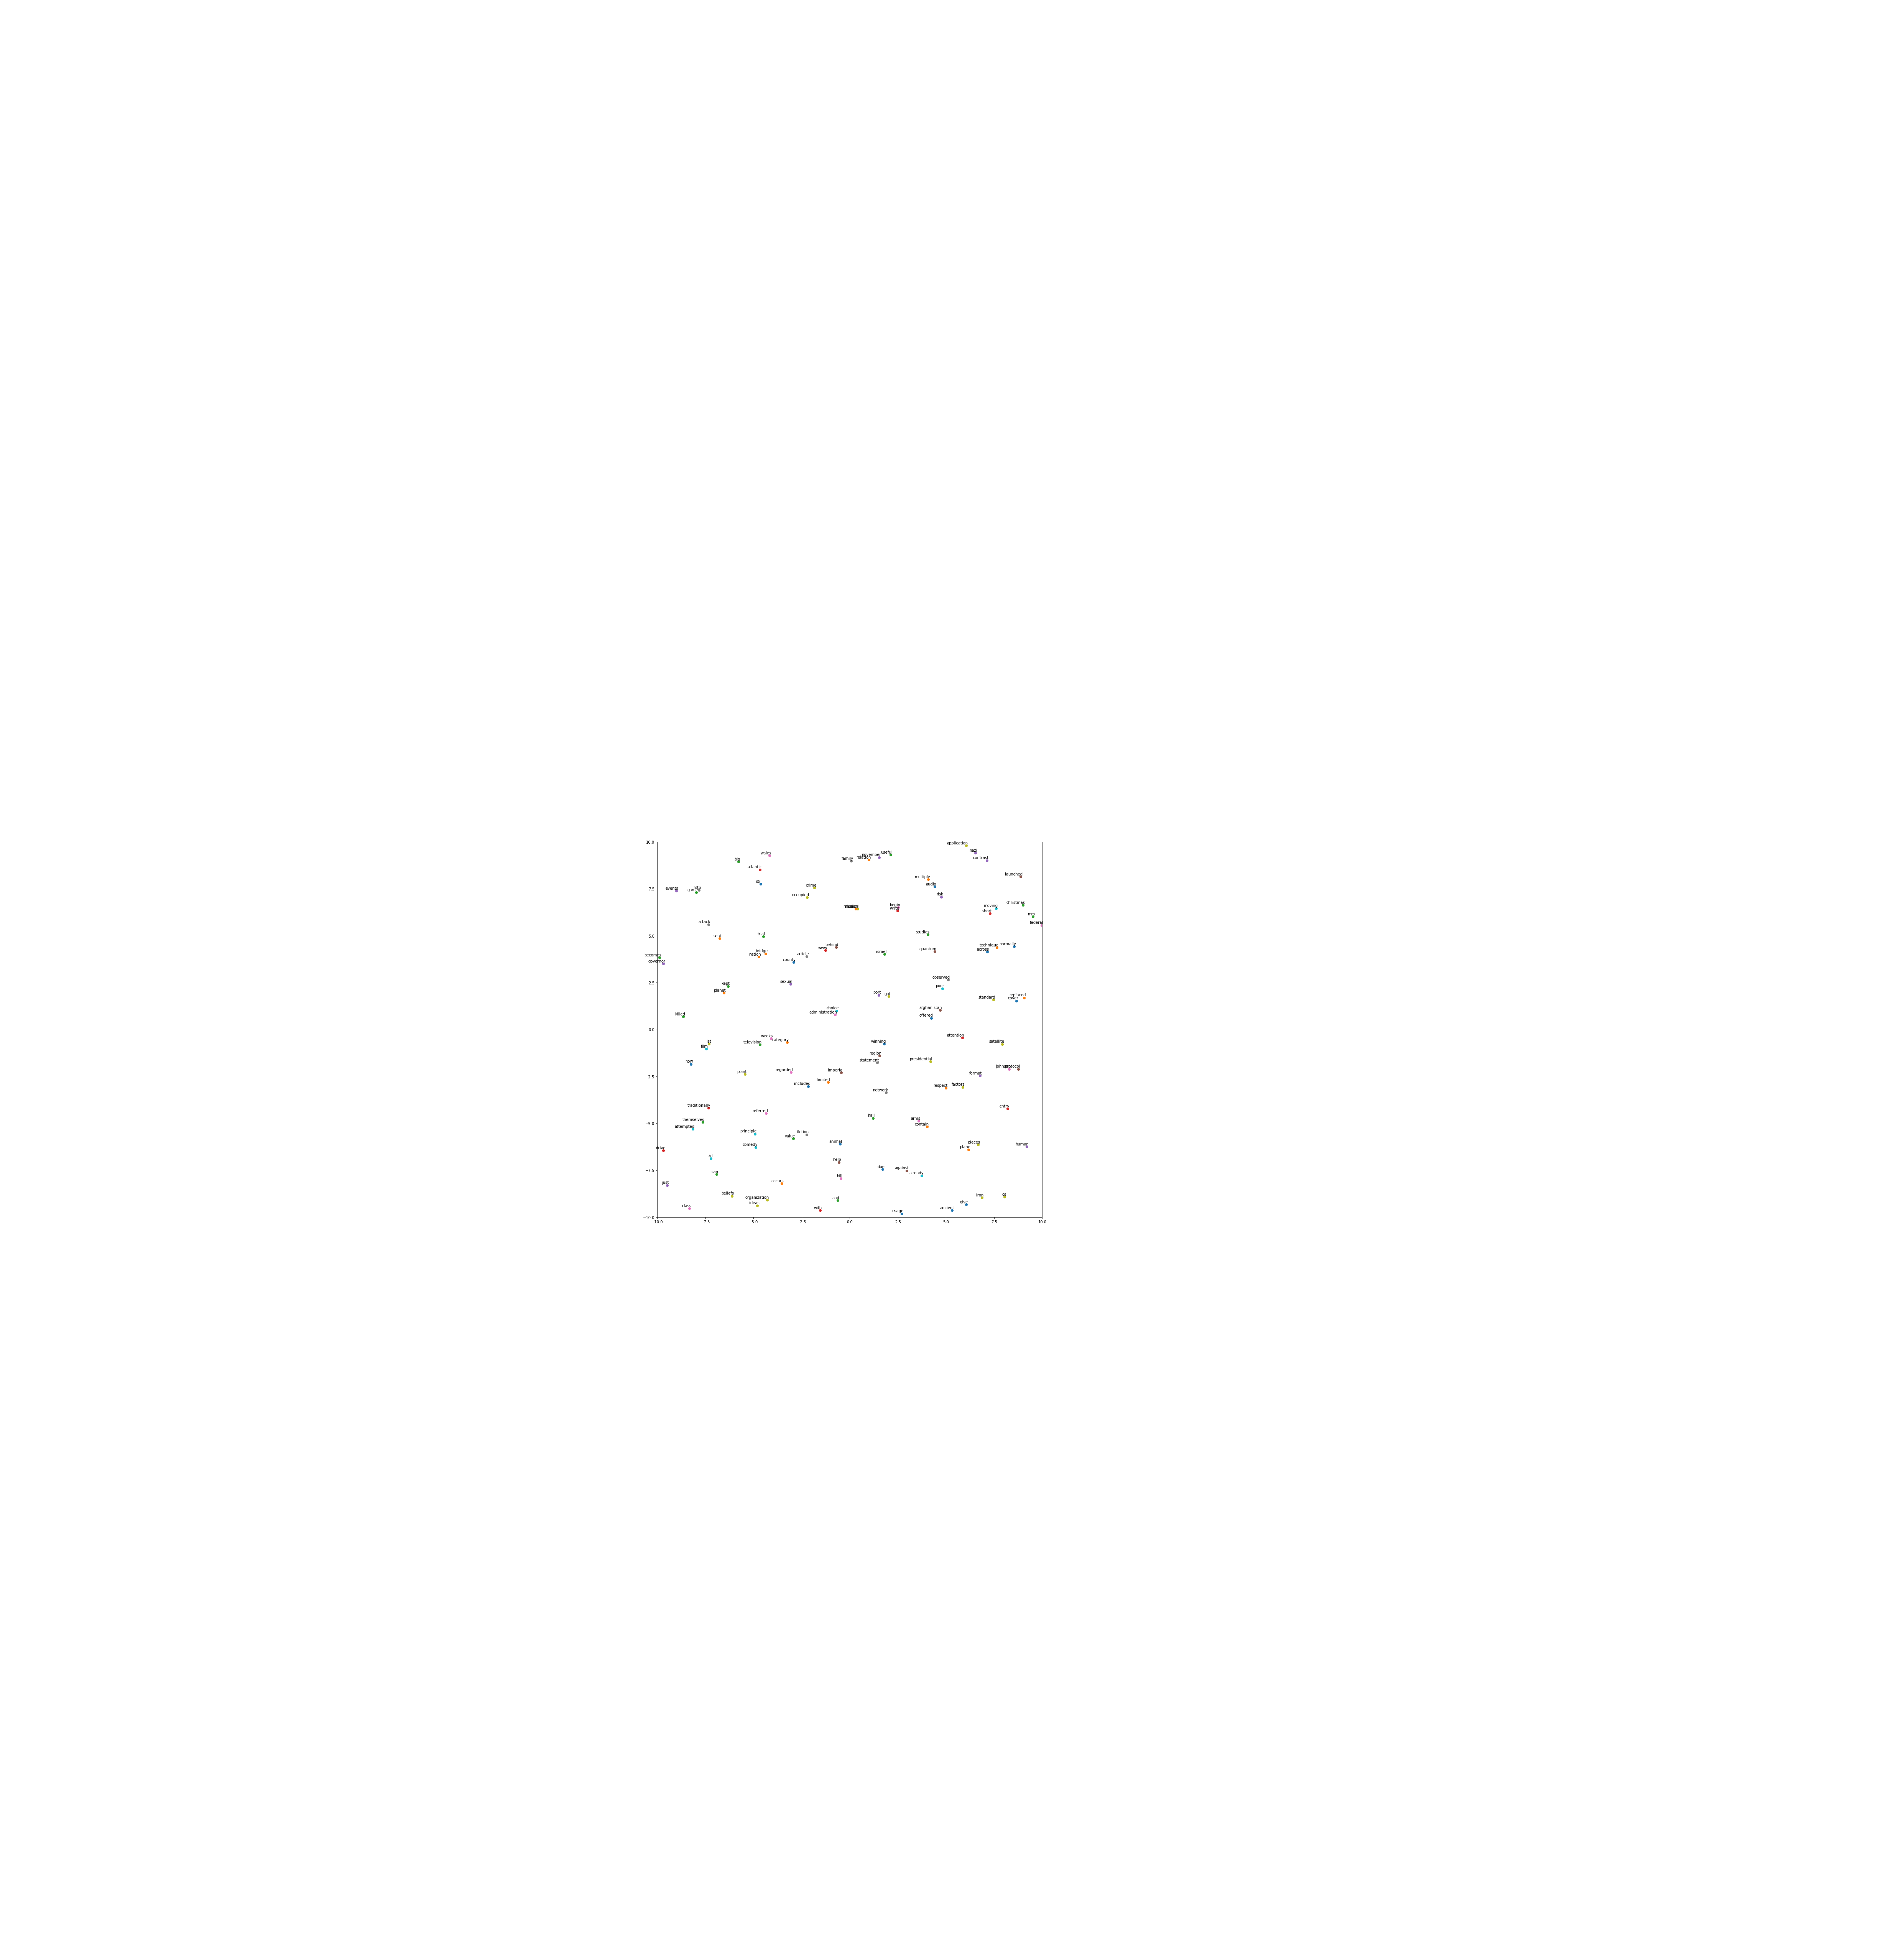

In [53]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

## Also check out gensim!

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [ ]:
np.save('trained_embeddings_200k_steps',final_embeddings)

# Great Job!